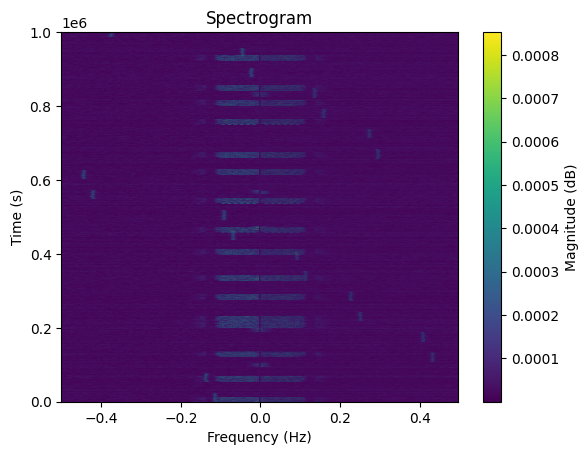

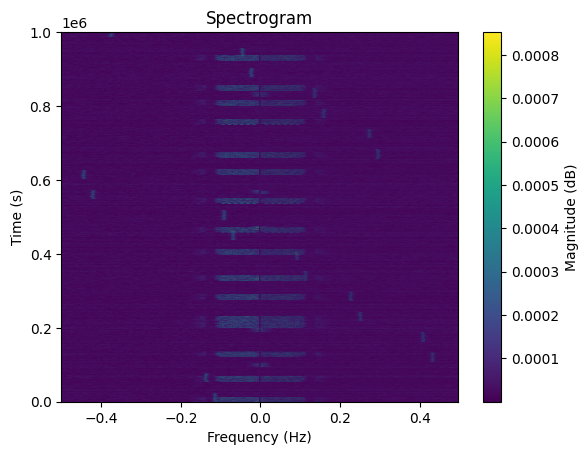

In [152]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import stft

# Raw list of complex numbers where the complex part ends in "i".
raw_data: pd.DataFrame = pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)

# Map the raw data into a numpy array of complex numbers.
# 
# The "i" in each row must be replaced with "j" because Python uses the engineering convention for
# representing complex numbers.
data: np.ndarray[complex] = raw_data.map(lambda row: np.csingle(row.replace('i', 'j')))[0]

# Sampling frequency
fs = 1  # Hz

# Calculate Short Time Fourier Transform of the signal. Sxx is the naming convention for the
# Power Spectral Density.
f, t, Sxx = stft(x=data, fs=fs, return_onesided=False)

np.clip(Sxx, 0.0001, 0.0005)

# Plot spectrogram
# Pass frequencies and time values for the X, Y values for the color mesh. 
plt.pcolormesh(f, t, np.abs(Sxx.T), shading="gouraud")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Time (s)')
plt.title('Spectrogram')
plt.colorbar(label='Magnitude (dB)')
plt.show()


# plt.plot(f, t, np.abs(Sxx.T), shading="gouraud")
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Time (s)')
# plt.title('Spectrogram')
# plt.colorbar(label='Magnitude (dB)')
# plt.show()